In [1]:
def get(phix,m):     # Returns phi only upto the no. of features 0 to m-1
    newphi = np.copy(phix.T)
    newphi = newphi[0:m]
    return newphi.T

def plot_all(x,hs,xl = 'X',yl = 'Y',legends = [''],xlog = False,scatterFirst = False, ylog = False):      # Plots all curves with x on X and all elements oh hs on Y, ll = xlabel, yl = ylabel, xlog = if x is on logarithmic scale, legends = legends
    plt.figure()
    plt.xlabel(xl)
    plt.ylabel(yl)
    if(xlog):
        plt.xscale('log')
    if(ylog):
        plt.yscale('log')
    if(scatterFirst):
        plt.scatter(x,hs[0],color = 'indigo')
    for h in hs[scatterFirst:]:
        plt.plot(x,h)
    plt.legend(legends)
    plt.show()

def make_batches(phix,tx,bs):                 # Returns the batches of phi,t with batch_size = bs
    N = phix.shape[0]
    newphi = np.copy(phix)
    newphi = np.concatenate((newphi,np.array([tx]).T),axis = 1)
    np.random.shuffle(newphi)
    sz = math.floor(N/bs)
    # print(sz,bs)
    newphi = newphi[0:sz*bs]
    N = phix.shape[0]
    newphi = np.array(np.split(newphi,sz))
    phis = []
    ts = []
    for ph in newphi:
        ts.append(ph.T[-1])
        phis.append((ph.T[0:-1]).T)
    return phis,ts

def MPPI(phi, t, m, lamda):
    phix = get(phi,m)
    wm = (( np.linalg.inv(lamda*np.eye(m) + (phix.T).dot(phix)).dot(phix.T)).dot(t))
    h = phix.dot(wm)
    return wm,h

def L1Error(h,t):   # h,t hypotheses and targets, the two vectors b/w which we need the norm
    return np.linalg.norm(h-t,1)

def LinfError(h,t): # h,t hypotheses and targets, the two vectors b/w which we need the norm
    return np.linalg.norm(h-t,np.inf)


def SSE(hi,ti):   # Returns Sum of Squares error between the hypothesis h and the target t
    N = hi.shape[0]
    cost = (1/N)*0.5*sum(np.square(hi-ti))
    return cost

def SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    return gd

def batch_gd(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phii.dot(w)
            except RuntimeWarning as e:
                return e
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h

def check(phi,t,m):
    N = phi.shape[0]
    batch_sizes =[]
    alphas = []
    for bs in [1,2,5,10,20,50,100]:
        batch_sizes.append(bs)
        alpha,cost = find_alpha(phi,t,bs,1e-5,1,m)
        alphas.append(alpha,cost)
        print(bs,alphas[-1])
    plt.plot(batch_sizes,alphas)

def find_alpha(phi,t,batch_size,l,r,lamda,m,errorf):
    mid = 0
    cost = 0
    for _ in range(5):
        mid = (l+r)/2
        output = batch_gd(phi,mid,t,10000,batch_size,lamda = lamda,m = m)
        if(isinstance(output,RuntimeWarning)):
            r = mid
        elif(output[1] > 1e6):
            r = mid
        else:
            cost = output[1]
            l =mid
    return l,cost

def Cross_Validation(phi,tx,alpha,parts,lamda,m,batch_size = 1,iters=1000,errorf=SSE,gradient=SSG,pinv = True):   # Finds cross validation Error for the given arguments
    # print(m,lamda)
    phix = get(phi,m)
    N = phix.shape[0]
    bs = math.floor(N/parts)
    alls = np.array_split(range(N),parts)
    test_error = 0.0
    training_error = 0.0
    if(parts == 1):
        if(pinv):
            wi,hi = MPPI(phi,tx,m,lamda)   
            costi = SSE(hi,tx)      # Represents the training error
        else:
            wi,costi,hi = batch_gd(phi = phi, alpha = alpha,tx = tx,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
        return costi
    else:
        for i in range(parts):
            phii = np.delete(phix,alls[i],axis = 0)
            ti = np.delete(tx,alls[i])
            if(pinv):
                wi,hi = MPPI(phii,ti,m,lamda)   
                hi = get(phii,m).dot(wi)
                costi = errorf(hi,ti)      # Represents the training error
            else:
                wi,costi,hi = batch_gd(phi = phii, alpha = alpha,tx = ti,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
                hi = get(phii,m).dot(wi)
                costi = errorf(hi,ti)      # Represents the training error
            # Wi and Hi are weights and hypothesis values at all inputs in this training set
            hypothesis_i = phix[alls[i]].dot(wi)    # Represents the hypothesis values at the test set
            training_error += costi # Increment total training error
            test_error += errorf(hypothesis_i,tx[alls[i]]) # Increment total testing error
    test_error /= parts
    training_error /= parts
    print(test_error,training_error)
    return test_error,training_error

In [2]:
import csv
import math
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
M = 100 # Order of poly is M-1
from random import randint as rand
with open("gaussian.csv", 'r') as f:
    data = list(csv.reader(f,delimiter = ','))
# data= data[0:20]
data = np.array(data)
data = np.array([[float(d[0]),float(d[1])] for d in data])
data = data[np.argsort(data[:,0])]
x = np.array([d[0] for d in data], dtype = 'float')
t = np.array([d[1] for d in data], dtype= 'float')
phi = np.array([[pow(xv,i) for i in range(M)] for xv in x])
N = t.size

In [28]:
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 5, lamda = 0, m = i, pinv = False, iters = 100000) for i in range(2,10)]

0.009026776208852368 0.007822391012009114
0.011044066549955425 0.008384320208227634
0.00726555237545383 0.006484549850190645
0.006918482226863757 0.007071635921838823
0.006786961014750833 0.007064681120623437
0.0061093641538868156 0.006097100677999466
0.005688342163805915 0.005228591498111585
0.005441206135803706 0.004845021130210732


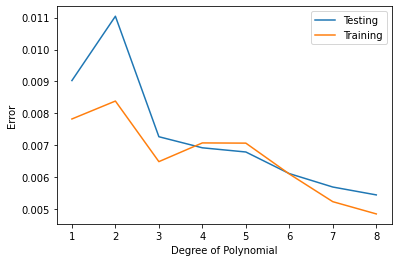

In [33]:
test,train = np.array(errors).T
plot_all(x = range(1,len(test)+1), hs = [test,train],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error',)

In [49]:
errors = [Cross_Validation(phi,t,alpha = 1e-4, batch_size = 1,parts = 4, lamda = 0, m = i) for i in range(1,10)]

NameError: name 'math' is not defined

In [4]:
arr = [pow(math.e,i) for i in range(-15,-3,2)]
errors = [Cross_Validation(phi,t,alpha = 0.5, batch_size = 5,parts = 4, lamda = i, m = 6, pinv =False) for i in arr]

0.030841630650987717 0.0102207080696084


KeyboardInterrupt: 

In [48]:
errors2 = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = SSE) for i in range(1,25)]
errors1 = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = L1Error) for i in range(1,25)]
errorsinf = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = LinfError) for i in range(1,25)]

0.00015847492759259074 0.00013090279907407426
0.00010525400825184138 7.704995553622541e-05
0.00011467205274946342 7.43762150706135e-05
0.00020232252909629613 6.132108314785445e-05
0.0009594828769734437 5.3708979371680855e-05
7.545663125603842e-07 6.259428968145995e-07
9.40892430245878e-07 6.250360011385251e-07
2.972048823988208e-06 6.19803713842074e-07
2.0679191088395532e-06 6.174612625987735e-07
2.4950403591645838e-05 6.088570465344818e-07
2.1106851131289645e-05 5.993178688974076e-07
1.5507553384721286e-05 7.927248185569158e-07
0.0029741095705847578 1.8050848709882844e-05
0.22624822493671184 0.0025250425115729597
0.46705210735357905 0.10323309264005445
32.376812574547515 1.3552899937466791
2065.2308667202533 147.24447734467978
30.31295389710133 23.723420776329466
97.13314181480993 132.52130556214075
63929.275968291135 4395.449024882712
943.8725844989847 3984.655571705811
96.57110497171213 122.47940834432879
12656.77117873583 2965.1650208711417
15734.41468160386 6235.186010547982
0.147

0.14775133333333254 0.00015847492759259074 0.02106588888888874


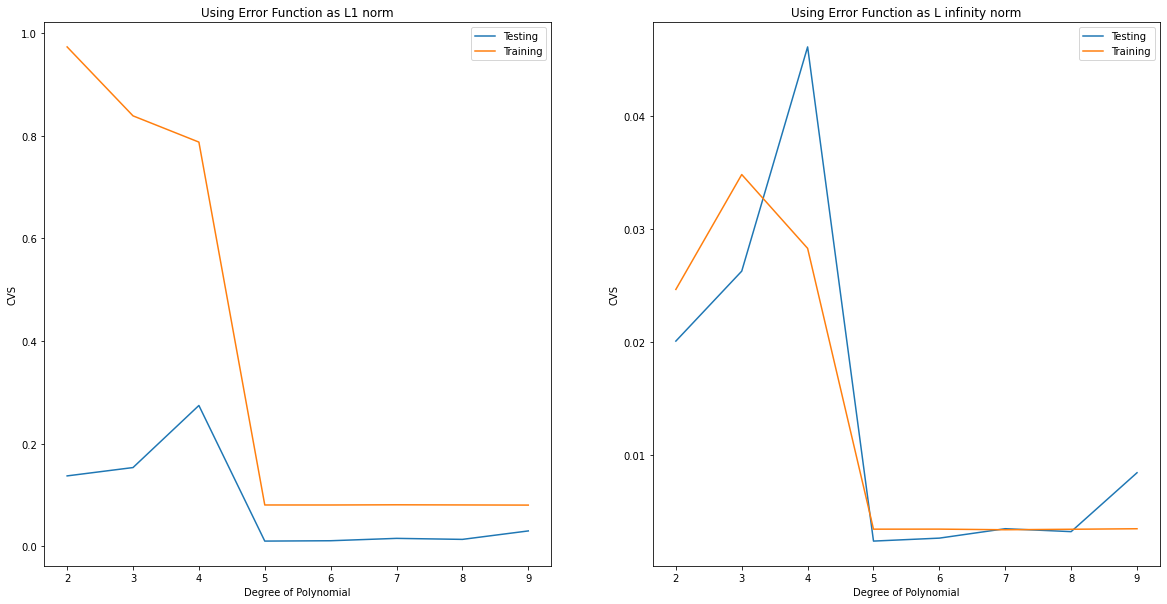

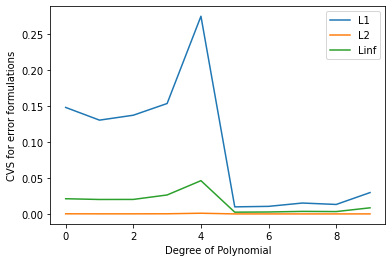

[array([1.47751333e-01, 1.30121027e-01, 1.36944106e-01, 1.53205745e-01,
       2.74279674e-01, 9.79336423e-03, 1.04817774e-02, 1.51009796e-02,
       1.31282167e-02, 2.96095241e-02, 2.84374175e-02, 2.41605885e-02,
       2.82505044e-01, 2.37218140e+00, 3.84552004e+00, 3.14824914e+01,
       2.36646621e+02, 5.43259216e+01, 8.10137351e+01, 1.34840673e+03,
       2.39842152e+02, 1.09757844e+02, 7.62401409e+02, 8.64810852e+02]), array([1.58474928e-04, 1.05254008e-04, 1.14672053e-04, 2.02322529e-04,
       9.59482877e-04, 7.54566313e-07, 9.40892430e-07, 2.97204882e-06,
       2.06791911e-06, 2.49504036e-05, 2.11068511e-05, 1.55075534e-05,
       2.97410957e-03, 2.26248225e-01, 4.67052107e-01, 3.23768126e+01,
       2.06523087e+03, 3.03129539e+01, 9.71331418e+01, 6.39292760e+04,
       9.43872584e+02, 9.65711050e+01, 1.26567712e+04, 1.57344147e+04]), array([2.10658889e-02, 2.00433486e-02, 2.01068928e-02, 2.62971115e-02,
       4.61353970e-02, 2.41229029e-03, 2.67460890e-03, 3.50783556e-03,
 

In [49]:
# Plots for size = 100

m = 10

s1,r1 = np.copy(np.array(errors1)).T
s2,r2 = np.copy(np.array(errors2)).T
s3,r3 = np.copy(np.array(errorsinf)).T
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(range(2,m),s1[2:m])
axs[0].plot(range(2,m),r1[2:m])
axs[0].set(xlabel = 'Degree of Polynomial', ylabel = 'CVS')
axs[0].legend(['Testing','Training'])
axs[0].set_title('Using Error Function as L1 norm')

axs[1].plot(range(2,m),s3[2:m])
axs[1].plot(range(2,m),r3[2:m])
axs[1].set(xlabel = 'Degree of Polynomial', ylabel = 'CVS')
axs[1].legend(['Testing','Training'])
axs[1].set_title('Using Error Function as L infinity norm')

print(s1[0],s2[0],s3[0])

# plot_all(x = range(2,m),hs = [s2[2:m],r2[2:m]],xl = 'Degree of Polynomial',yl="CVS with L2",legends=['Testing','Training'])
# plot_all(x = range(2,m),hs = [s1[2:m],r1[2:m]],xl = 'Degree of Polynomial',yl="CVS with L1",legends=['Testing','Training'])
# plot_all(x = range(2,m),hs = [s3[2:m],r3[2:m]],xl = 'Degree of Polynomial',yl="CVS with Linf",legends=['Testing','Training'])

plot_all(x = range(m),hs = [s1[0:m],s2[0:m],s3[0:m]],xl = 'Degree of Polynomial',yl="CVS for error formulations",legends=['L1','L2','Linf'])

print([s1,s2,s3])

In [51]:
error2 = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = SSE) for i in range(1,25)]
error1 = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = L1Error) for i in range(1,25)]
errorinf = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = LinfError) for i in range(1,25)]

0.00020436891512345593 0.00016449230709876663
8.756927043032547e-05 6.187960659259317e-05
0.00012460715546626204 5.776848751724138e-05
8.713625365561535e-05 3.3233959984339714e-05
0.0005481135410993509 2.789958370084803e-05
1.168384949540133e-06 7.235011974792041e-07
1.8860145639030877e-06 7.0245355169555e-07
9.842355070965812e-05 6.794301615348073e-07
0.00011750429900210888 5.666551307334834e-07
0.00012485038030418945 5.301044766793004e-07
0.005606910677581822 5.249187170576138e-07
0.001970114915960022 3.940257285008055e-05
2795.7523568543857 223.84764910083922
6.104745115231092 4.805388250211687
22633.25466532316 322.1175366956196
1127.3750645428313 190.89043007383697
130.76688127459724 202.56799996436249
1033.2362806066808 181.02340079746472
1978.4735505827207 726.71111036001
8764.256539810081 5001.872802420586
809.6124915295566 1676.5968728535493
6505.732569379386 4431.612568702788
4653.595770110837 3750.063682855217
4988.153415318393 464.7353388841367
0.03456444444444422 0.2775144

0.03456444444444422 0.020089444444444382 0.14775133333333254 0.02106588888888874


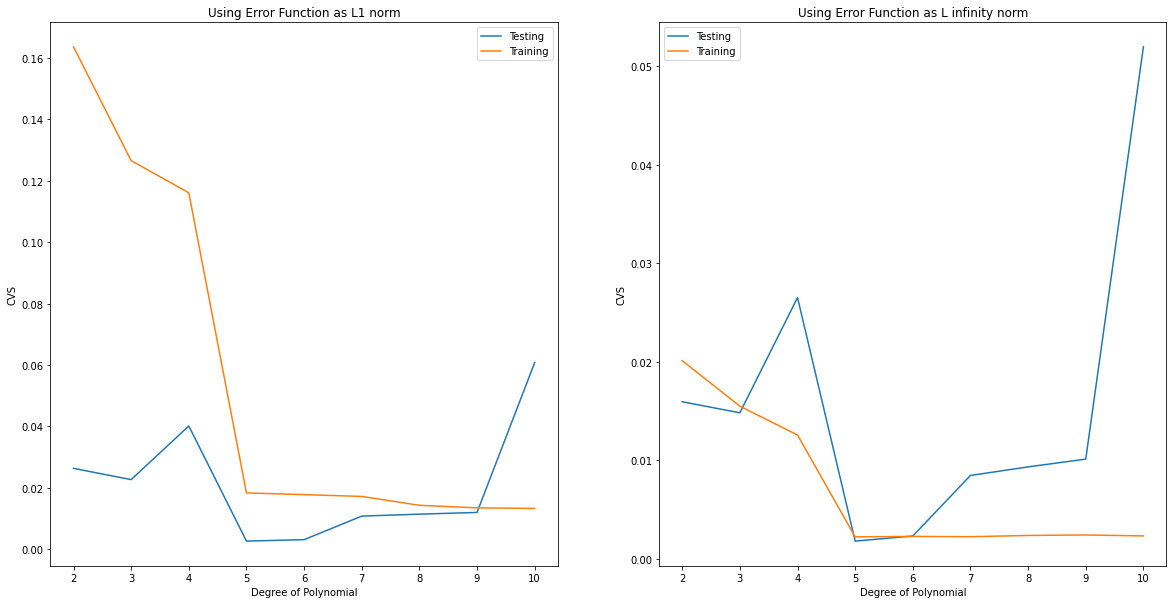

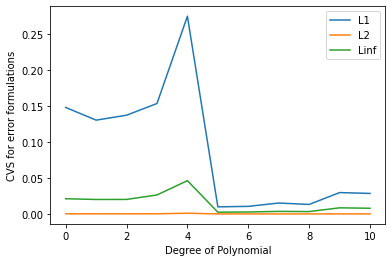

In [54]:
# Plots for size = 20
m = 11

xs1,xr1 = np.copy(np.array(error1)).T
xs2,xr2 = np.copy(np.array(error2)).T
xs3,xr3 = np.copy(np.array(errorinf)).T
fig,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(range(2,m),xs1[2:m])
axs[0].plot(range(2,m),xr1[2:m])
axs[0].set(xlabel = 'Degree of Polynomial', ylabel = 'CVS')
axs[0].legend(['Testing','Training'])
axs[0].set_title('Using Error Function as L1 norm')

axs[1].plot(range(2,m),xs3[2:m])
axs[1].plot(range(2,m),xr3[2:m])
axs[1].set(xlabel = 'Degree of Polynomial', ylabel = 'CVS')
axs[1].legend(['Testing','Training'])
axs[1].set_title('Using Error Function as L infinity norm')

print(xs1[0],xs3[0],s1[0],s3[0])

plot_all(x = range(m),hs = [s1[0:m],s2[0:m],s3[0:m]],xl = 'Degree of Polynomial',yl="CVS for error formulations",legends=['L1','L2','Linf'])

In [105]:
# For size = 20
lamdas = [pow(10,i) for i in range(-10,0)]
errs = [Cross_Validation(phi,t,alpha = 1e-4, batch_size = 1, parts = 4, lamda = lamda, m = 6) for lamda in lamdas]

1.7199842383184437e-05 6.554379672609493e-07
1.7134188348171473e-05 6.554379910085206e-07
1.6491982499124344e-05 6.554403500713177e-07
1.1394001501247094e-05 6.556615025650237e-07
2.9667332052200507e-05 6.688959479301642e-07
0.0003269897338528488 9.755238932026217e-07
0.0005283225131861804 5.490119617915096e-06
0.0009379296548140532 1.58180141198425e-05
0.0035876814918373496 6.872694057394171e-05
0.03247083150974998 0.0030362304215866796


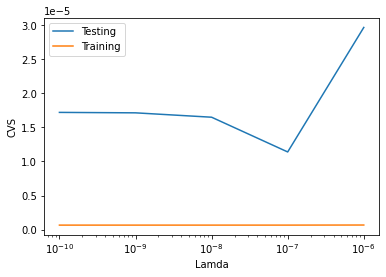

In [106]:
m = 5
ts1,tr1 = np.copy(np.array(errs)).T
ts1 = ts1[0:m]
tr1 = tr1[0:m]
plot_all(x = lamdas[0:m],hs = [ts1,tr1],xl = 'Lamda',yl="CVS",legends=['Testing','Training'],xlog = True)

In [118]:
# For size = 100
lamdas = [pow(10,i) for i in range(-20,0)]
errs = [Cross_Validation(phi,t,alpha = 1e-4, batch_size = 1, parts = 4, lamda = lamda, m = 6) for lamda in lamdas]

0.002547247539840032 0.0007875497049335772
0.002547247539840032 0.0007875497049335772
0.002547247539840032 0.0007875497049335772
0.002547247539840032 0.0007875497049335772
0.0025472475399614756 0.0007875497049335743
0.002547247540207204 0.00078754970493359
0.002547247629217812 0.0007875497049335932
0.002547247617119434 0.000787549704933547
0.0025472476660797464 0.0007875497049336275
0.0025472486861458253 0.0007875497049337022
0.0025472572842684654 0.0007875497049370832
0.0025473461600003175 0.0007875497052814534
0.0025483136786695767 0.0007875497396919676
0.0025658767395751333 0.0007875531526793651
0.003341171851205439 0.0007878683330203077
0.014958033529382395 0.0008048708683663251
0.04921370229804899 0.001097175615353959
0.08182229151479466 0.003088620543056602
0.03933990587679043 0.005926936020556936
0.07369906652125166 0.01386156730692665


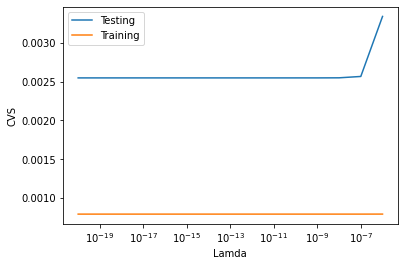

In [122]:
m = 15
ts1,tr1 = np.copy(np.array(errs)).T
ts1 = ts1[0:m]
tr1 = tr1[0:m]
plot_all(x = lamdas[0:m],hs = [ts1,tr1],xl = 'Lamda',yl="CVS",legends=['Testing','Training'],xlog = True)

In [21]:
# Size 20
# Solving using Gradient Descent: bs = 1
error2 = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, errorf = SSE, pinv = False) for i in range(1,15)]

0.014305173696135364 0.01283615201183957
0.3518951732849482 0.2701137955882639
0.259441141164173 0.1844853959458134
0.19849307103260333 0.12901272340116604
0.21380830457499542 0.14504131644228135
0.2606738318642655 0.1843415773834626
0.3100895215011894 0.21987880836476897
0.3523877047176681 0.24483712597260252
0.3844229588897942 0.2573793428706919
0.404967545067892 0.2574670694412685
0.4135247079707582 0.24665023851961201
0.4099547227327989 0.2282774990100442
0.3949645384232862 0.20727829893893432
0.37077724701289194 0.1892920454593329


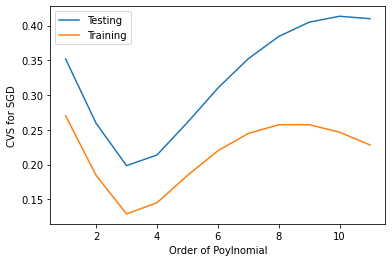

In [24]:
ts,tr = np.copy(np.array(error2)).T
m = 12
ts = ts[1:m]
tr = tr[1:m]
plot_all(x = range(1,m), hs = [ts,tr],xl = 'Order of Poylnomial', yl="CVS for SGD",legends=['Testing','Training'])

In [13]:
# Size 20
# Solving using Gradient Descent: bs = 20
error3 = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 10, parts = 1, lamda = 0, m = i, errorf = SSE, pinv = False) for i in range(1,15)]

0.0 10


TypeError: slice indices must be integers or None or have an __index__ method

In [5]:
ts,tr = np.copy(np.array(error3)).T
m = 12
ts = ts[1:m]
tr = tr[1:m]
plot_all(x = range(1,m), hs = [ts,tr],xl = 'Order of Poylnomial', yl="CVS for SGD",legends=['Testing','Training'])

NameError: name 'error3' is not defined

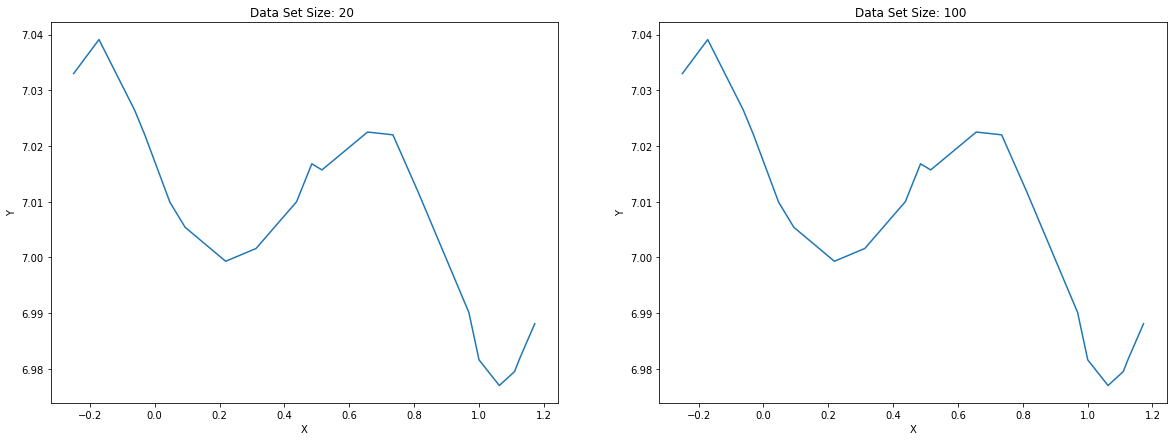

In [55]:
fig, axs = plt.subplots(1,2,figsize = [20,7])
it = np.argsort(data[0:20][:,0])
it2 = np.argsort(data[:,0])
axs[0].plot(x[it],t[it])
axs[0].set(xlabel = "X",ylabel="Y")
axs[1].set(xlabel = "X",ylabel="Y")
axs[0].set_title("Data Set Size: 20 ")
axs[1].set_title("Data Set Size: 100 ")
axs[1].plot(x[it2],t[it2])

[ 7.01740246 -0.14714376  0.11583423  1.18530836 -2.16558266  0.97810731]


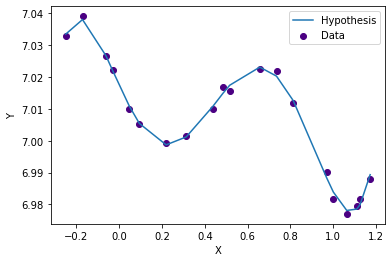

-3.509645725152666e-08
0.0012140975409763498
1.4740328390048194e-06


In [65]:
wx,hx = MPPI(phi,t,6,1e-7)
print(wx)
plot_all(x = x,hs = [t,hx],scatterFirst=True,xl='X',yl='Y',legends=['Hypothesis','Data'])
noise = hx -t
std = np.std(noise)
print(np.mean(noise))
print(np.std(noise))
print(np.std(noise)**2)
print()

[ 7.01773369 -0.15136816  0.11437092  1.22406385 -2.22398847  1.00313742]


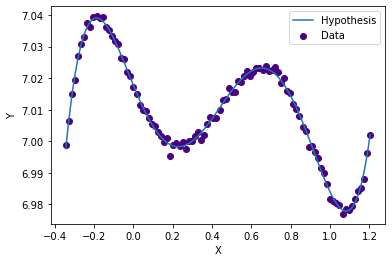

-7.016774876689169e-09
0.0011210881117776157
1.2568385543690998e-06


In [68]:
wx1,hx1 = MPPI(phi,t,6,1e-7)
print(wx1)
plot_all(x = x,hs = [t,hx1],scatterFirst=True,xl='X',yl='Y',legends=['Hypothesis','Data'])
noise1 = hx1 - t
std = np.std(noise1)
print(np.mean(noise1))
print(np.std(noise1))
print(np.std(noise1)**2)

In [4]:
def gd_errors(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    errors = []
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phix.dot(w)
            except RuntimeWarning as e:
                return e
        errors.append(errorf(h,tx))
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h,errors

In [110]:
out1 = gd_errors(phi = phi, alpha = 1e-2, tx = t, iters = 10000, batch_size = 1, m = 6, lamda =0)
out2 = gd_errors(phi = phi, alpha = 1e-2, tx = t, iters = 10000, batch_size = 5, m = 6, lamda =0)
out3 = gd_errors(phi = phi, alpha = 1e-2, tx = t, iters = 10000, batch_size = 20, m = 6, lamda =0)

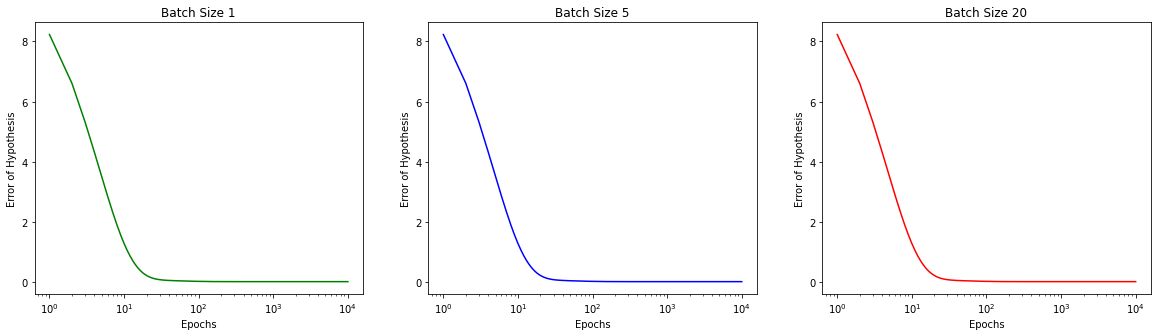

In [115]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(range(1,10001),out1[3],'green')
axs[1].plot(range(1,10001),out1[3],'blue')
axs[2].plot(range(1,10001),out1[3],'red')
axs[0].set(xlabel = 'Epochs',ylabel = 'Error of Hypothesis')
axs[1].set(xlabel = 'Epochs',ylabel = 'Error of Hypothesis')
axs[2].set(xlabel = 'Epochs',ylabel = 'Error of Hypothesis')
axs[0].set_title("Batch Size 1")
axs[1].set_title("Batch Size 5")
axs[2].set_title("Batch Size 20")
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')


In [5]:
out1 = gd_errors(phi = phi, alpha = 1e-2, tx = t, iters = 1000, batch_size = 1, m = 6, lamda =0)
out2 = gd_errors(phi = phi, alpha = 1e-2, tx = t, iters = 1000, batch_size = 20, m = 6, lamda =0)
out3 = gd_errors(phi = phi, alpha = 1e-2, tx = t, iters = 1000, batch_size = 100, m = 6, lamda =0)

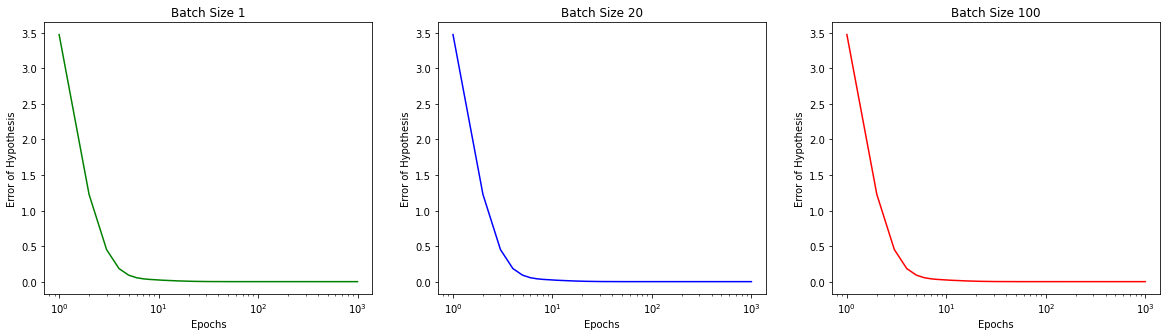

In [7]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(range(1,1001),out1[3],'green')
axs[1].plot(range(1,1001),out1[3],'blue')
axs[2].plot(range(1,1001),out1[3],'red')
axs[0].set(xlabel = 'Epochs',ylabel = 'Error of Hypothesis')
axs[1].set(xlabel = 'Epochs',ylabel = 'Error of Hypothesis')
axs[2].set(xlabel = 'Epochs',ylabel = 'Error of Hypothesis')
axs[0].set_title("Batch Size 1")
axs[1].set_title("Batch Size 20")
axs[2].set_title("Batch Size 100")
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')